In [1]:
!pip install kaggel
!kaggle datasets download -d splcher/animefacedataset
!unzip animefacedataset.zip -d animefacedataset


ERROR: Could not find a version that satisfies the requirement kaggel (from versions: none)
ERROR: No matching distribution found for kaggel
Dataset URL: https://www.kaggle.com/datasets/splcher/animefacedataset
License(s): DbCL-1.0
 98%|███████████████████████████████████████▉ | 385M/395M [00:03<00:00, 139MB/s]
100%|█████████████████████████████████████████| 395M/395M [00:03<00:00, 124MB/s]
Archive:  animefacedataset.zip
  inflating: animefacedataset/images/0_2000.jpg  
  inflating: animefacedataset/images/10000_2004.jpg  
  inflating: animefacedataset/images/10001_2004.jpg  
  inflating: animefacedataset/images/10002_2004.jpg  
  inflating: animefacedataset/images/10003_2004.jpg  
  inflating: animefacedataset/images/10004_2004.jpg  
  inflating: animefacedataset/images/10005_2004.jpg  
  inflating: animefacedataset/images/10006_2004.jpg  
  inflating: animefacedataset/images/10007_2004.jpg  
  inflating: animefacedataset/images/10008_2004.jpg  
  inflating: animefacedataset/images/10

In [3]:
import os
from PIL import Image
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split

anime_faces_path = 'animefacedataset/images'

transform = transforms.Compose([
    transforms.Resize((128, 128)), 
    transforms.ToTensor(), 
    transforms.Normalize((0.5,), (0.5,)) 
])

class AnimeFacesDataset(Dataset):
    def __init__(self, root, transform=None):
        self.root = root
        self.transform = transform
        self.image_files = [os.path.join(root, f) for f in os.listdir(root) if f.endswith('.jpg')]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, 0  

train_dataset = AnimeFacesDataset(root=anime_faces_path, transform=transform)

batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

print(f'Training dataset size: {len(train_dataset)}')

for images, labels in train_loader:
    print(f'Batch size: {images.size()}')
    break


Training dataset size: 63565
Batch size: torch.Size([8, 3, 128, 128])


In [4]:
!ls

animefacedataset  animefacedataset.zip


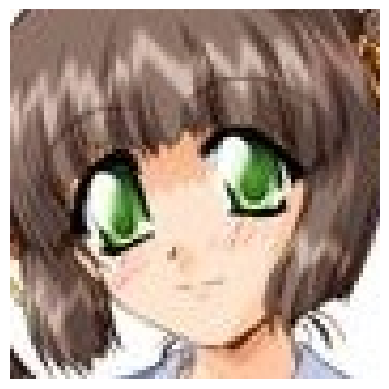

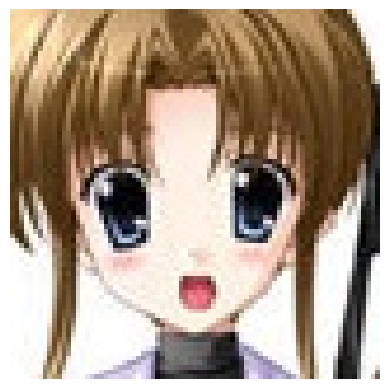

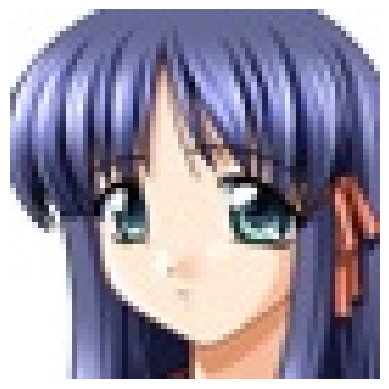

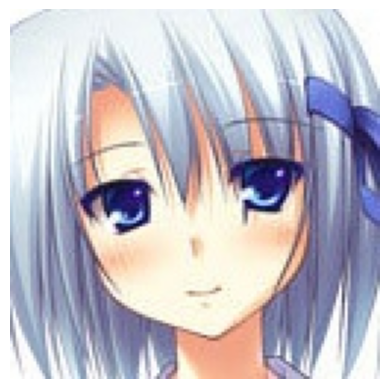

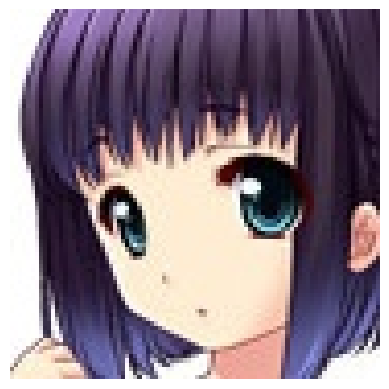

In [8]:
import os
import random
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img

anime_faces_path = 'animefacedataset/images'

anime_images = os.listdir(anime_faces_path)
sample_anime_images = random.sample(anime_images, 5)

for img_name in sample_anime_images:
    img_path = os.path.join(anime_faces_path, img_name)
    img = load_img(img_path)
    plt.imshow(img)
    plt.axis('off')
    plt.show()

Adding augmentation to our dataset 

Training dataset size: 63565
Batch 1


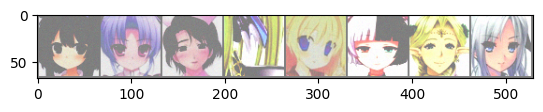

Batch 2


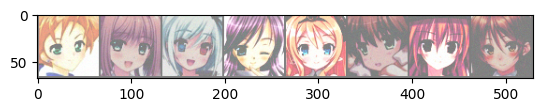

Batch 3


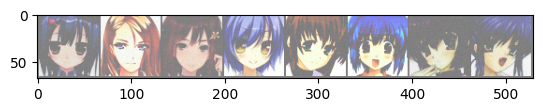

Batch 4


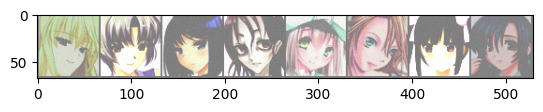

Batch 5


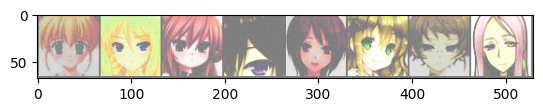

Batch 6


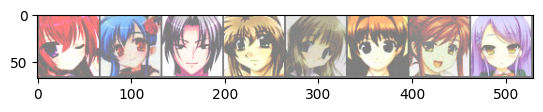

In [9]:
import os
from PIL import Image
import torch
from torchvision import transforms, utils
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np

anime_faces_path = 'animefacedataset/images'


class AddGaussianNoise(object):
    def __init__(self, mean=0.0, std=1.0):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean

    def __repr__(self):
        return self.__class__.__name__ + f'(mean={self.mean}, std={self.std})'


transform = transforms.Compose([
    transforms.Resize((64, 64)),  
    transforms.ToTensor(),  
    transforms.Normalize((0.5,), (0.5,)), 
    transforms.RandomHorizontalFlip(),  
    transforms.ColorJitter(brightness=0.3, contrast=0.2, saturation=0.2, hue=0.1),  
    AddGaussianNoise(0., 0.03)  
])

class AnimeFacesDataset(Dataset):
    def __init__(self, root, transform=None):
        self.root = root
        self.transform = transform
        self.image_files = [os.path.join(root, f) for f in os.listdir(root) if f.endswith('.jpg')]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, 0 

train_dataset = AnimeFacesDataset(root=anime_faces_path, transform=transform)

batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

print(f'Training dataset size: {len(train_dataset)}')

def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

for batch_idx, (images, labels) in enumerate(train_loader):
    print(f'Batch {batch_idx + 1}')
    imshow(utils.make_grid(images))
    if batch_idx == 5:
        break


now we make dataloader and show some augmented version of data

In [10]:
!pip install torchsummary
import os
from PIL import Image
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split
from torchsummary import summary
import torch.nn as nn
import torch.nn.functional as F

anime_faces_path = 'animefacedataset/images'


class AddGaussianNoise(object):
    def __init__(self, mean=0.0, std=1.0):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean

    def __repr__(self):
        return self.__class__.__name__ + f'(mean={self.mean}, std={self.std})'

transform = transforms.Compose([
    transforms.Resize((64, 64)),  
    transforms.ToTensor(),  
    transforms.Normalize((0.5,), (0.5,)), 
    transforms.RandomHorizontalFlip(),  
    transforms.ColorJitter(brightness=0.3, contrast=0.2, saturation=0.2, hue=0.1),  
    AddGaussianNoise(0., 0.03)  
])


class AnimeFacesDataset(Dataset):
    def __init__(self, root, transform=None):
        self.root = root
        self.transform = transform
        self.image_files = [os.path.join(root, f) for f in os.listdir(root) if f.endswith('.jpg')]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, 0  

dataset = AnimeFacesDataset(root=anime_faces_path, transform=transform)

train_size = len(dataset)
train_dataset = dataset

batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

print(f'Total dataset size: {len(dataset)}')
print(f'Training dataset size: {len(train_dataset)}')

latent_dim = 40


/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Total dataset size: 63565
Training dataset size: 63565


In [12]:
torch.cuda.is_available()

True

In [13]:

class Encoder(nn.Module):
    def __init__(self, latent_dim):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(8 * 8 * 128, 256)
        self.fc2_mean = nn.Linear(256, latent_dim)
        self.fc2_log_var = nn.Linear(256, latent_dim)

    def forward(self, x):
        x = F.leaky_relu(self.conv1(x), negative_slope=0.2)
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = F.leaky_relu(self.conv2(x), negative_slope=0.2)
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = F.leaky_relu(self.conv3(x), negative_slope=0.2)
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = self.flatten(x)
        x = F.leaky_relu(self.fc1(x), negative_slope=0.2)
        z_mean = self.fc2_mean(x)
        z_log_var = self.fc2_log_var(x)
        return z_mean, z_log_var

class Decoder(nn.Module):
    def __init__(self, latent_dim):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_dim, 256)
        self.fc2 = nn.Linear(256, 8 * 8 * 128)
        self.deconv1 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.deconv2 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.deconv3 = nn.ConvTranspose2d(32, 32, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.final_layer = nn.ConvTranspose2d(32, 3, kernel_size=3, padding=1)

    def forward(self, z):
        x = F.leaky_relu(self.fc1(z), negative_slope=0.2)
        x = F.leaky_relu(self.fc2(x), negative_slope=0.2)
        x = x.view(-1, 128, 8, 8)
        x = F.leaky_relu(self.deconv1(x), negative_slope=0.2)
        x = F.leaky_relu(self.deconv2(x), negative_slope=0.2)
        x = F.leaky_relu(self.deconv3(x), negative_slope=0.2)
        x = torch.sigmoid(self.final_layer(x))
        return x

class VAE(nn.Module):
    def __init__(self, encoder, decoder):
        super(VAE, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def reparameterize(self, z_mean, z_log_var):
        std = torch.exp(0.5 * z_log_var)
        eps = torch.randn_like(std)
        return z_mean + eps * std

    def forward(self, x):
        z_mean, z_log_var = self.encoder(x)
        z = self.reparameterize(z_mean, z_log_var)
        reconstructed = self.decoder(z)
        kl_loss = -0.5 * torch.sum(1 + z_log_var - z_mean.pow(2) - z_log_var.exp(), dim=1)
        kl_loss = kl_loss.mean()  
        return reconstructed, kl_loss

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

encoder = Encoder(latent_dim).to(device)
decoder = Decoder(latent_dim).to(device)
vae = VAE(encoder, decoder).to(device)

summary(vae, (3, 64, 64))

reconstruction_loss_fn = nn.MSELoss(reduction='sum')
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)

losses = []
reconstruction_losses = []
kl_losses = []

num_epochs = 10
for epoch in range(num_epochs):
    total_loss = 0
    total_reconstruction_loss = 0
    total_kl_loss = 0
    for batch_idx, (images, _) in enumerate(train_loader):
        images = images.to(device)
        optimizer.zero_grad()
        reconstructed, kl_loss = vae(images)
        reconstruction_loss = reconstruction_loss_fn(reconstructed, images)
        loss = reconstruction_loss + kl_loss
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        total_reconstruction_loss += reconstruction_loss.item()
        total_kl_loss += kl_loss.item()

    avg_loss = total_loss / len(train_loader.dataset)
    avg_reconstruction_loss = total_reconstruction_loss / len(train_loader.dataset)
    avg_kl_loss = total_kl_loss / len(train_loader.dataset)
    
    losses.append(avg_loss)
    reconstruction_losses.append(avg_reconstruction_loss)
    kl_losses.append(avg_kl_loss)
    
    print(f'Epoch {epoch + 1}/{num_epochs}')
    print(f' - Loss: {avg_loss:.4f} - Reconstruction Loss: {avg_reconstruction_loss:.4f} ')




----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 64, 64]             896
            Conv2d-2           [-1, 64, 32, 32]          18,496
            Conv2d-3          [-1, 128, 16, 16]          73,856
           Flatten-4                 [-1, 8192]               0
            Linear-5                  [-1, 256]       2,097,408
            Linear-6                   [-1, 40]          10,280
            Linear-7                   [-1, 40]          10,280
           Encoder-8       [[-1, 40], [-1, 40]]               0
            Linear-9                  [-1, 256]          10,496
           Linear-10                 [-1, 8192]       2,105,344
  ConvTranspose2d-11           [-1, 64, 16, 16]          73,792
  ConvTranspose2d-12           [-1, 32, 32, 32]          18,464
  ConvTranspose2d-13           [-1, 32, 64, 64]           9,248
  ConvTranspose2d-14            [-1, 3,

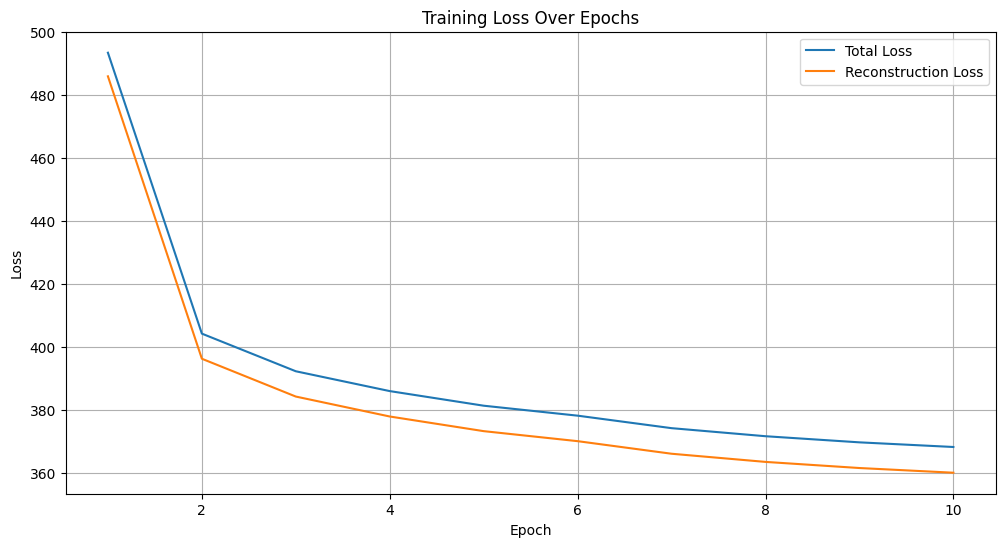

In [18]:

plt.figure(figsize=(12, 6))
plt.plot(range(1, num_epochs + 1), losses, label='Total Loss')
plt.plot(range(1, num_epochs + 1), reconstruction_losses, label='Reconstruction Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()


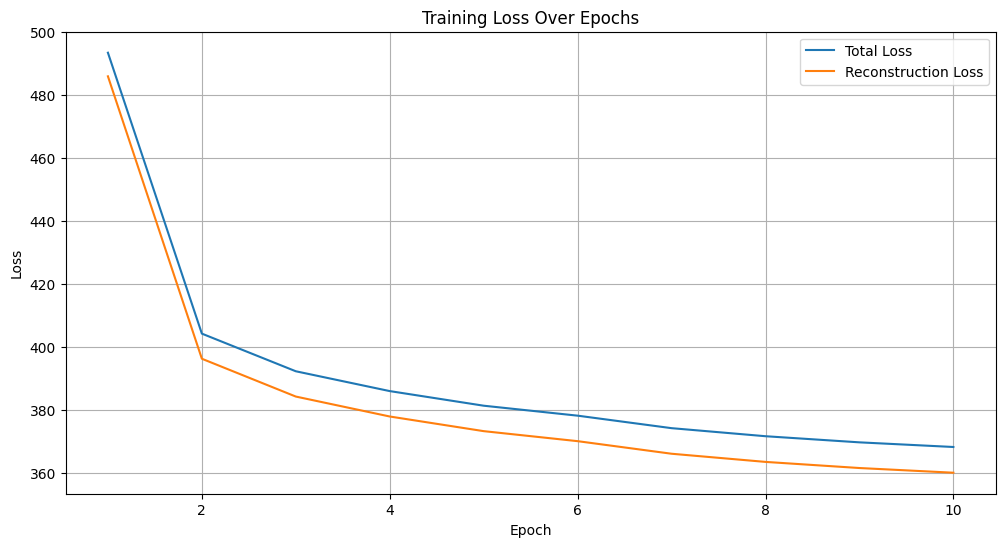

In [19]:
plt.figure(figsize=(12, 6))
plt.plot(range(1, num_epochs + 1), losses, label='Total Loss')
plt.plot(range(1, num_epochs + 1), reconstruction_losses, label='Reconstruction Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()


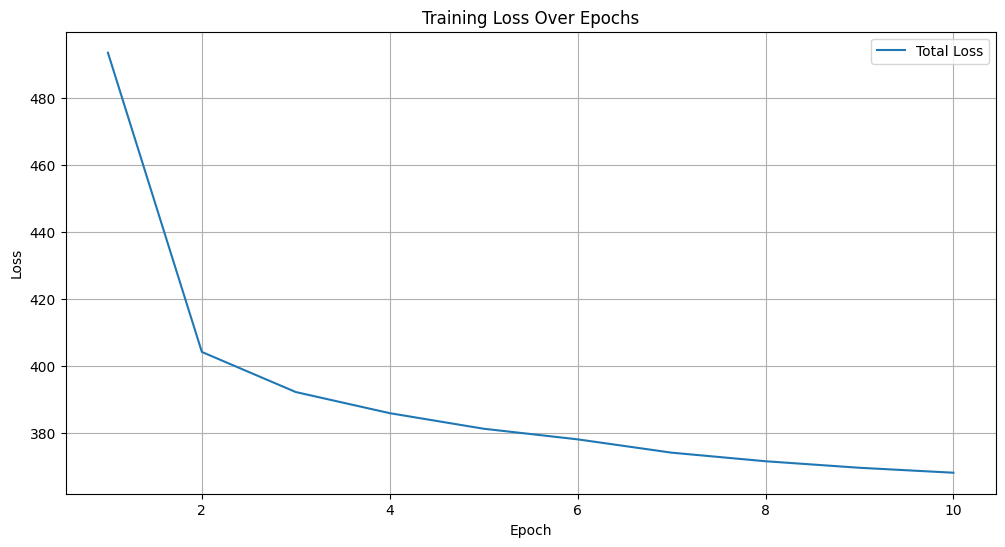

In [20]:
# Plot the training losses
plt.figure(figsize=(12, 6))
plt.plot(range(1, num_epochs + 1), losses, label='Total Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()


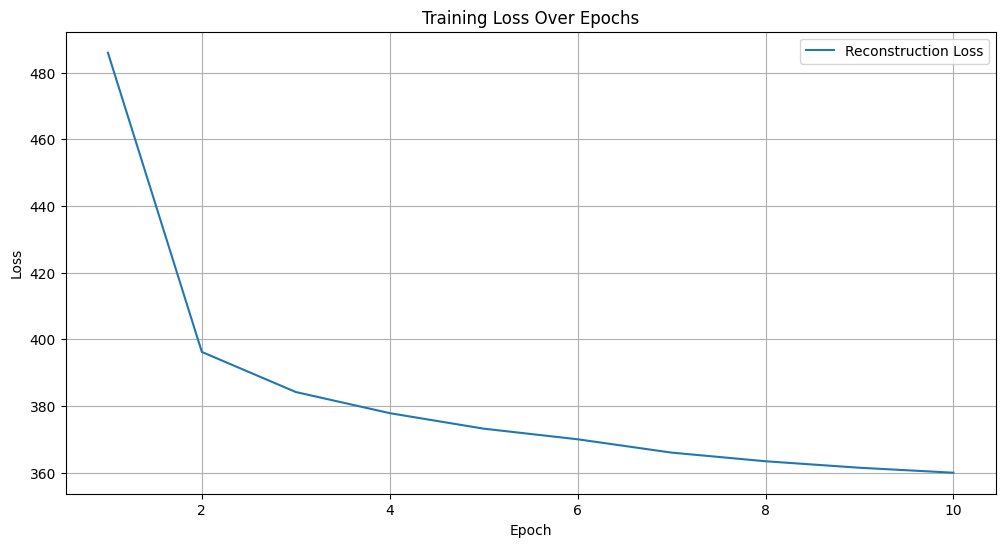

In [21]:
# Plot the training losses
plt.figure(figsize=(12, 6))
plt.plot(range(1, num_epochs + 1), reconstruction_losses, label='Reconstruction Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()


Estimated mean of the latent dimensions:
[-6.83164150e-02 -1.60908550e-01  6.26810566e-02  1.27617538e-01
  2.26012453e-01 -6.96671903e-02  1.23119049e-01  2.79737059e-02
 -1.29522860e-01 -1.07780784e-01  4.81617078e-02 -1.18303560e-01
 -6.61338642e-02 -3.54066163e-01 -1.28479183e-01  6.67999536e-02
  1.48708010e-02 -9.75410640e-02  1.29563473e-02  1.35428520e-04
  1.53318256e-01 -1.29187360e-01  1.27897635e-01 -1.63531199e-01
  8.54520574e-02 -1.52534917e-01 -1.82211116e-01  2.21496746e-02
  1.85614109e-01  3.14347267e-01  2.53137231e-01 -1.21048093e-01
 -1.36291981e-02 -2.70775586e-01 -1.39849335e-01  2.67031640e-01
 -1.21805288e-01 -3.68180066e-01  1.46795049e-01  2.75569230e-01]
Estimated variance of the latent dimensions:
[0.00173297 0.00302336 0.00311938 0.00288946 0.00231235 0.00404116
 0.00337738 0.0039651  0.00405097 0.0024277  0.00191759 0.00279001
 0.00332265 0.00107364 0.0044356  0.00321372 0.00281197 0.00249818
 0.00271556 0.00194728 0.00303114 0.00129537 0.0032535  0.0024

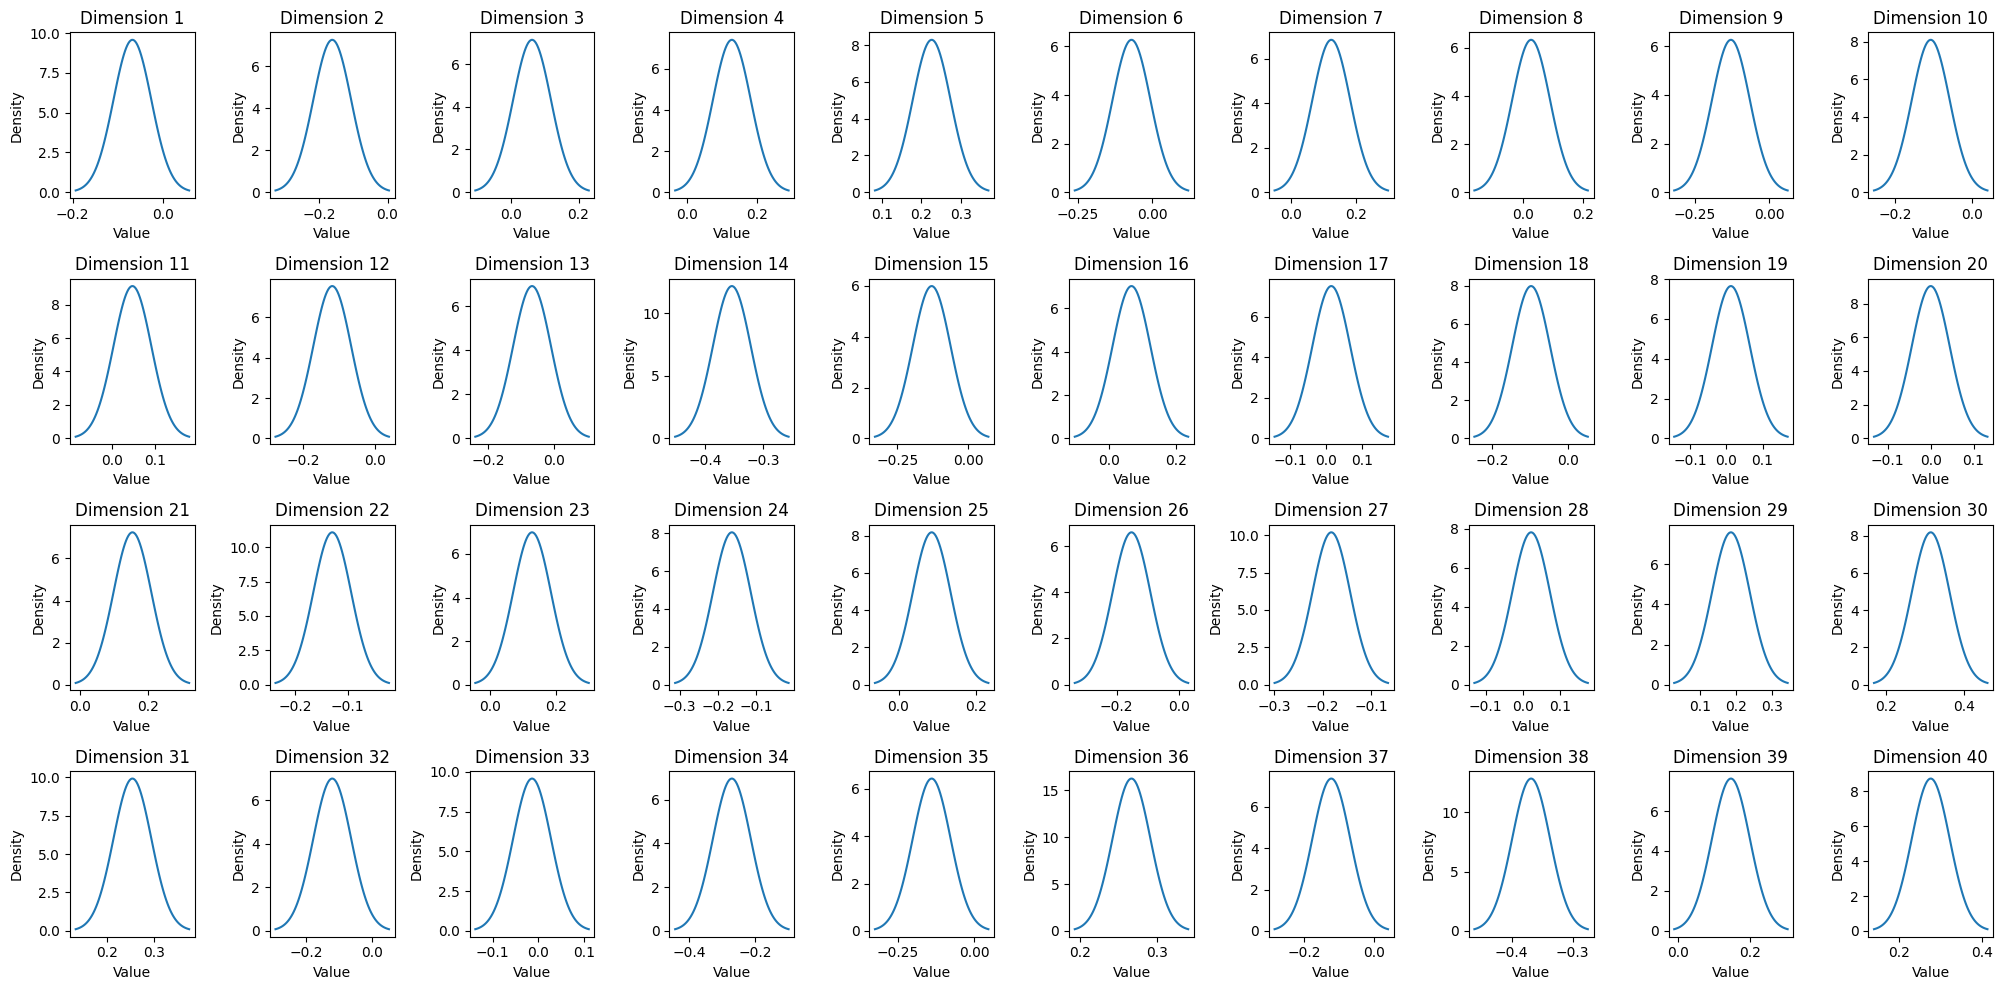

In [123]:
import numpy as np
vae.eval()
latent_means = []
latent_log_vars = []
with torch.no_grad():
    for batch_idx, (images, _) in enumerate(train_loader):
        images = images.to(device)
        z_mean, z_log_var = vae.encoder(images)
        latent_means.append(z_mean.cpu().numpy())
        latent_log_vars.append(z_log_var.cpu().numpy())
        if batch_idx == 10:  
            break

latent_means = np.concatenate(latent_means, axis=0)
latent_log_vars = np.concatenate(latent_log_vars, axis=0)

estimated_mean = np.mean(latent_means, axis=0)
estimated_variance = np.mean(np.exp(latent_log_vars), axis=0)

print("Estimated mean of the latent dimensions:")
print(estimated_mean)

print("Estimated variance of the latent dimensions:")
print(estimated_variance)

def plot_gaussian(ax, mean, variance, dimension):
    sigma = np.sqrt(variance)
    x = np.linspace(mean - 3*sigma, mean + 3*sigma, 100)
    y = (1/(sigma * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mean) / sigma)**2)
    ax.plot(x, y, label=f'Dimension {dimension+1}')
    ax.set_title(f'Dimension {dimension+1}')
    ax.set_xlabel('Value')
    ax.set_ylabel('Density')

fig, axes = plt.subplots(4, 10, figsize=(20, 10))
axes = axes.flatten()
for i in range(estimated_mean.shape[0]):
    plot_gaussian(axes[i], estimated_mean[i], estimated_variance[i], i)

plt.tight_layout()
plt.show()

Generated Images


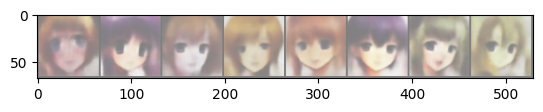

In [105]:
from torchvision import transforms, utils
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
# Save the trained model
torch.save(vae.state_dict(), 'vae_anime_faces.pth')

# Generate and display images from noise
vae.eval()
with torch.no_grad():
    z = torch.randn(8, latent_dim).to(device)
    generated_images = decoder(z)

# Function to display images
def show_image(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.cpu().numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

print("Generated Images")
show_image(utils.make_grid(generated_images.cpu()))

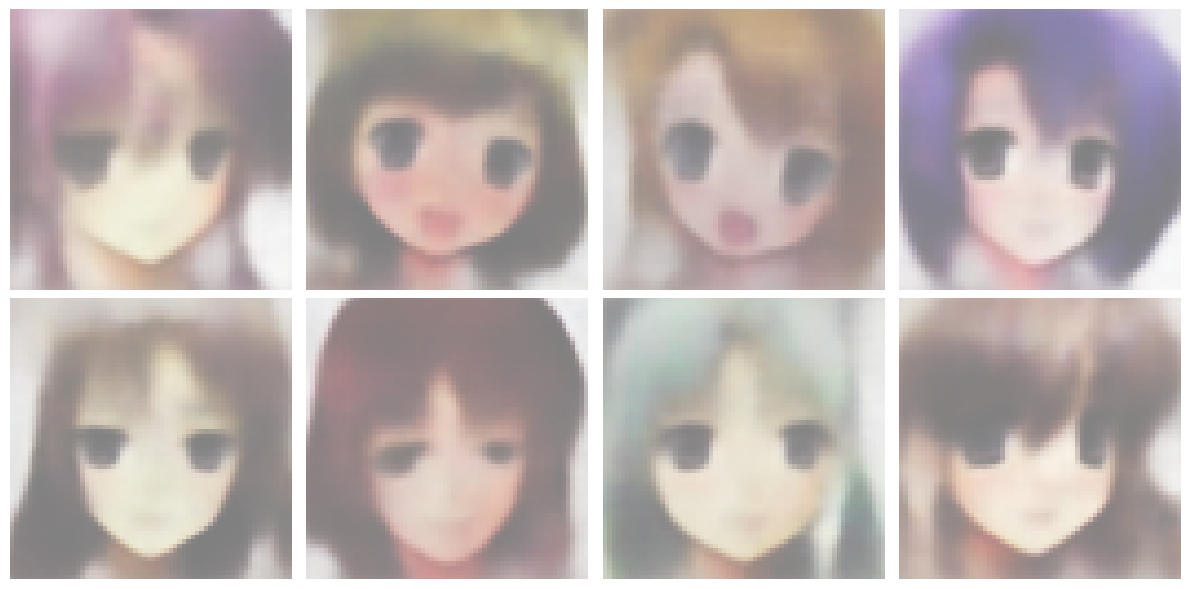

In [39]:
# Save the trained model
torch.save(vae.state_dict(), 'vae_anime_faces.pth')

# Generate and display images from noise
vae.eval()
with torch.no_grad():
    z = torch.randn(8, latent_dim).to(device)   # Reduce the scale of the noise to be closer to zero
    generated_images = decoder(z)

# Display generated images using matplotlib subplots
fig, axes = plt.subplots(2, 4, figsize=(12, 6))  # 2 rows and 4 columns
axes = axes.flatten()
for i in range(8):
    ax = axes[i]
    img = generated_images[i] / 2 + 0.5  # unnormalize
    img = img.cpu().numpy().transpose(1, 2, 0)
    ax.imshow(img)
    ax.axis('off')
plt.tight_layout()
plt.show()

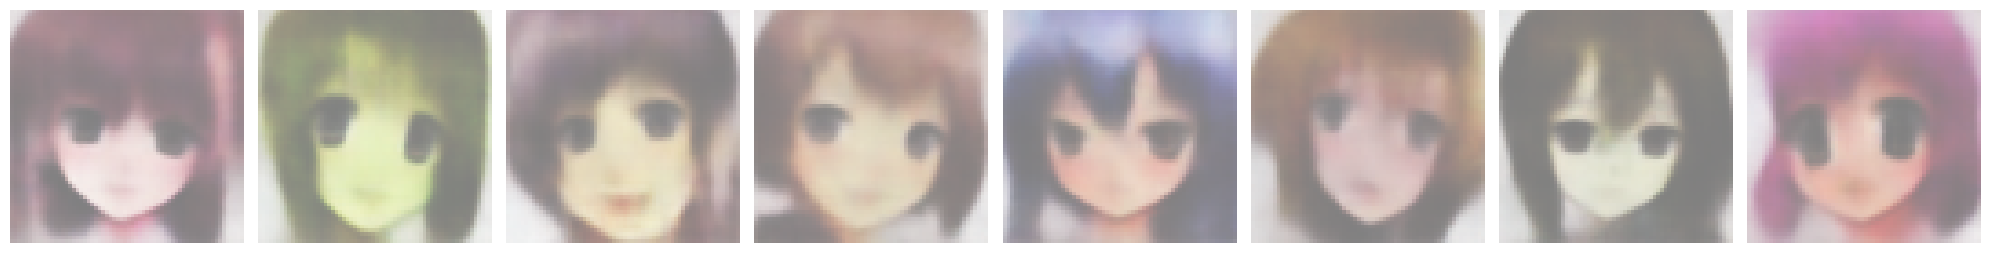

In [19]:
# Generate and display images from noise
vae.eval()
with torch.no_grad():
    z = torch.randn(8, latent_dim).to(device)   # Reduce the scale of the noise to be closer to zero
    generated_images = decoder(z)

# Display generated images using matplotlib subplots
fig, axes = plt.subplots(1, 8, figsize=(20, 4))  # 1 row and 8 columns
axes = axes.flatten()
for i in range(8):
    ax = axes[i]
    img = generated_images[i] / 2 + 0.5  # unnormalize
    img = img.cpu().numpy().transpose(1, 2, 0)
    ax.imshow(img)
    ax.axis('off')
plt.tight_layout()
plt.show()


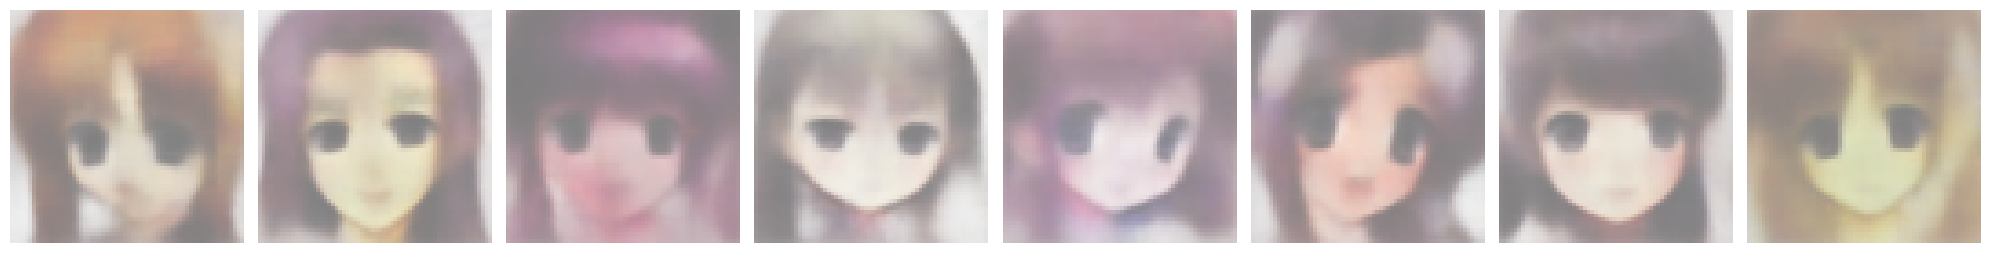

In [45]:
# Generate and display images from noise
vae.eval()
with torch.no_grad():
    z = torch.randn(8, latent_dim).to(device)   # Reduce the scale of the noise to be closer to zero
    generated_images = decoder(z)

# Display generated images using matplotlib subplots
fig, axes = plt.subplots(1, 8, figsize=(20, 4))  # 1 row and 8 columns
axes = axes.flatten()
for i in range(8):
    ax = axes[i]
    img = generated_images[i] / 2 + 0.5  # unnormalize
    img = img.cpu().numpy().transpose(1, 2, 0)
    ax.imshow(img)
    ax.axis('off')
plt.tight_layout()
plt.show()


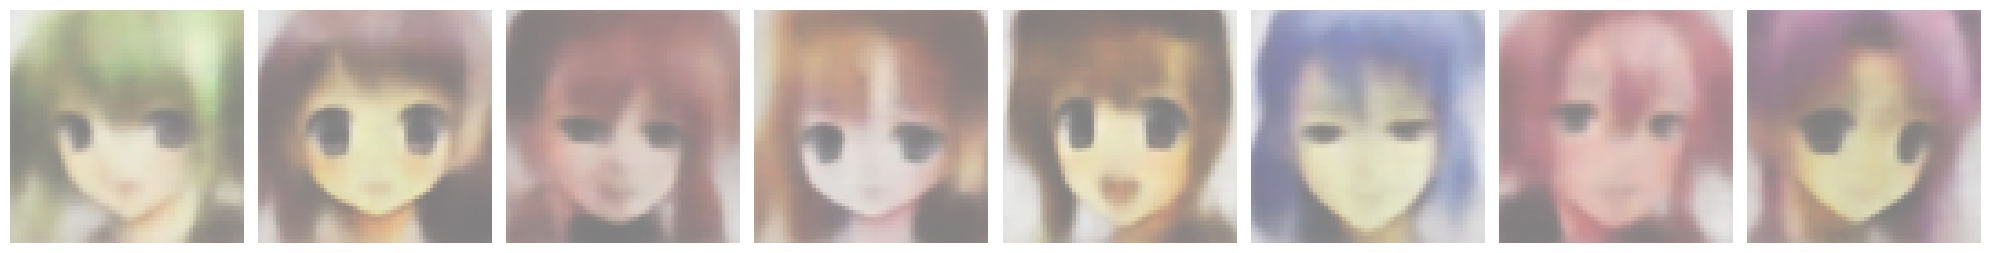

In [31]:
# Generate and display images from noise
vae.eval()
with torch.no_grad():
    z = torch.randn(8, latent_dim).to(device)   # Reduce the scale of the noise to be closer to zero
    generated_images = decoder(z)

# Display generated images using matplotlib subplots
fig, axes = plt.subplots(1, 8, figsize=(20, 4))  # 1 row and 8 columns
axes = axes.flatten()
for i in range(8):
    ax = axes[i]
    img = generated_images[i] / 2 + 0.5  # unnormalize
    img = img.cpu().numpy().transpose(1, 2, 0)
    ax.imshow(img)
    ax.axis('off')
plt.tight_layout()
plt.show()
